## Importing Libraries

In [ ]:
import re
import nltk
import pandas as pd
import random
import matplotlib.pyplot as plt
import nltk
import numpy as np
import seaborn as sns
import joblib


from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
from google.colab import drive
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/sentiment_data/trainingandtestdata

/content/drive/MyDrive/sentiment_data/trainingandtestdata


In [ ]:
ls

Final_notebook_sentiment_analysis_with_cleanup-2.ipynb
Final_notebook_sentiment_analysis_with_common_neutral.ipynb
final_test.ipynb
glove_embeddings/
logistic_regression_model_with_cleaning.pkl
logistic_regression_model_without_cleaning.pkl
lr_model.pkl
svc_model.pkl
testdata.manual.2009.06.14.csv
tfidf_vectorizer.pkl
tfidf_vectorizer_with_cleaning.pkl
tfidf_vectorizer_without_cleaning.pkl
training.1600000.processed.noemoticon.csv


In [ ]:
# Load the training and test datasets
train_file_path = 'training.1600000.processed.noemoticon.csv'
test_file_path = 'testdata.manual.2009.06.14.csv'

# The training dataset does not have a header
train_columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
train_data = pd.read_csv(train_file_path, names=train_columns, encoding='latin1')

# The test dataset does not have a header
test_columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
test_data = pd.read_csv(test_file_path, names=test_columns, encoding='latin1')

# Display the first few rows of each dataset
print("Training Data:")
print(train_data.head())

print("\nTest Data:")
print(test_data.head())


Training Data:
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

Test Data:
   target  ids                          date     flag      user  \
0       4    3  Mon May 11 03:17:40 UTC 2009  kindle2    tpryan   
1       4    4  

### Cleaning the text with links and stop words

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    words = word_tokenize(text)
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    text = ' '.join(words)
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

### Lets see the distribution in the training data

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

Text(0.5, 1.0, 'Dataset labels distribuition')

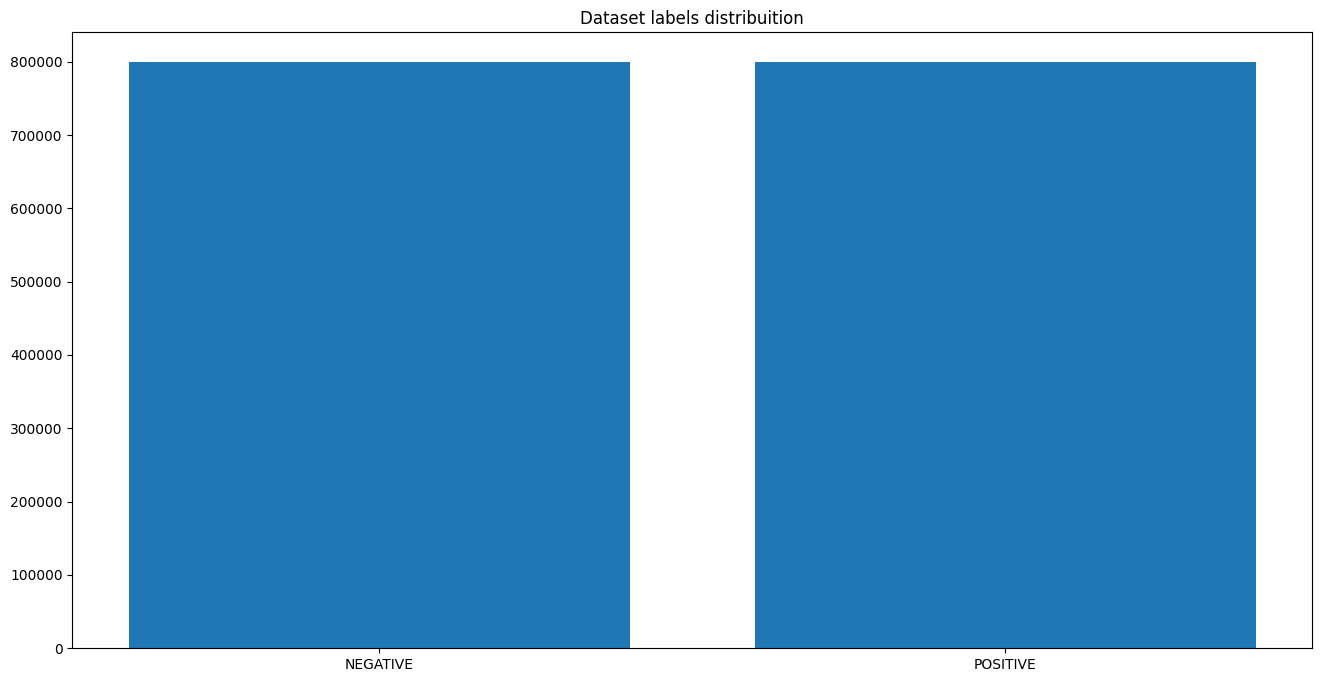

In [ ]:
train_data.target = train_data.target.apply(lambda x: decode_sentiment(x))
target_cnt = Counter(train_data.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

There are no neutral sentiment words present

In [ ]:
random_idx_list = [random.randint(1,len(train_data.text)) for i in range(10)] # creates random indexes to choose from dataframe
train_data.loc[random_idx_list,:].head(10)

,target,ids,date,flag,user,text
115923,NEGATIVE,1827344234,Sun May 17 10:30:48 PDT 2009,NO_QUERY,gingercaz,realli hate new msn keep spam peopl im offlin
670823,NEGATIVE,2246677619,Fri Jun 19 17:57:41 PDT 2009,NO_QUERY,figurescaitie13,shop
64822,NEGATIVE,1688964611,Sun May 03 12:18:59 PDT 2009,NO_QUERY,Valentin00,shut uppppp gon na come back soon
686992,NEGATIVE,2251165180,Sat Jun 20 02:38:26 PDT 2009,NO_QUERY,TheMichelleJoh,noth tv tonight nonfoxtel wish foxtel
39035,NEGATIVE,1573431827,Tue Apr 21 01:08:26 PDT 2009,NO_QUERY,notJeremy,want old want millionair back less person stor...
1098825,POSITIVE,1970518775,Sat May 30 04:11:23 PDT 2009,NO_QUERY,tmofee,reason chang caus node dont offer anymor gig
474512,NEGATIVE,2177351770,Mon Jun 15 05:57:12 PDT 2009,NO_QUERY,puertorockin,wonder weekend went
1192641,POSITIVE,1984106309,Sun May 31 14:27:18 PDT 2009,NO_QUERY,mstephaniejamil,go miley simpli ador song got nice mix countri
102087,NEGATIVE,1794783481,Thu May 14 06:33:05 PDT 2009,NO_QUERY,PoynterPerve,hate feel cant work hope feel better soon babe x
941852,POSITIVE,1794394134,Thu May 14 05:42:41 PDT 2009,NO_QUERY,jonnabrooks,isol late day storm expect today love


In [ ]:
from sklearn.model_selection import train_test_split
processed_text = train_data['text']
sentiment = train_data['target']
X_train, X_test, y_train, y_test = train_test_split(processed_text, sentiment, test_size=0.05, random_state=0)

### TF-IDF Vectorization

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')

Vectoriser fitted.


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [ ]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Training models on the train_test_split data

              precision    recall  f1-score   support

    NEGATIVE       0.81      0.78      0.79     39989
    POSITIVE       0.79      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



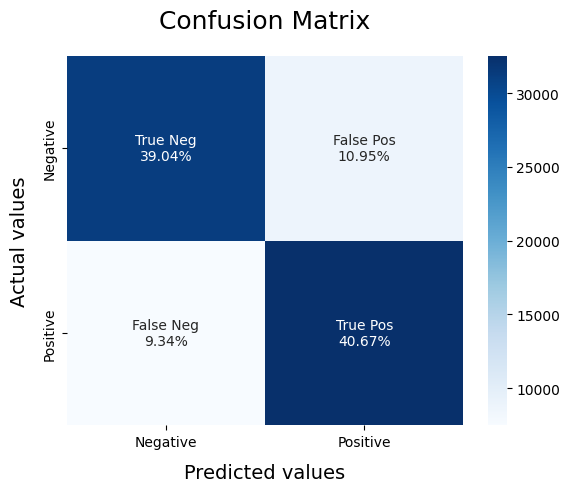

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.77      0.78     39989
    POSITIVE       0.77      0.80      0.79     40011

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



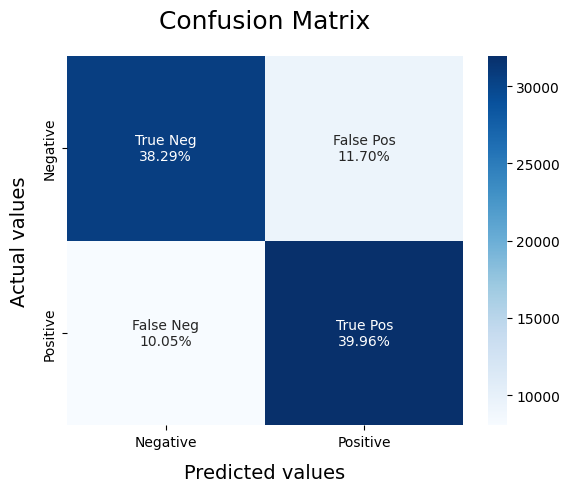

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.75      0.77     39989
    POSITIVE       0.76      0.81      0.79     40011

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



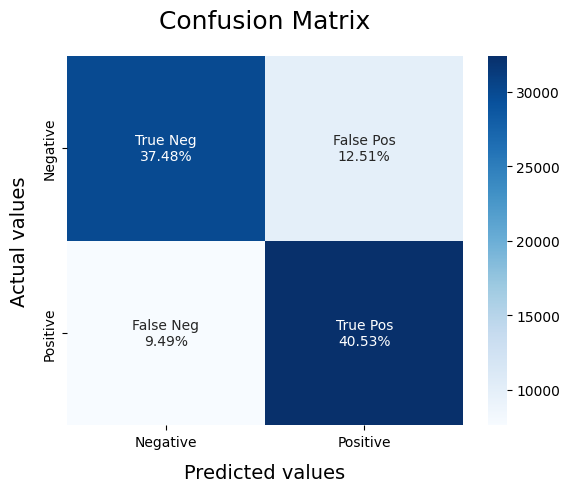

In [ ]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

### Validating trained models on test data which has neutral sentiment as well

In [ ]:
test_data['target'] = test_data['target'].map(decode_map)

In [ ]:
def model_test_evaluate(model, X_test, y_test):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))


In [ ]:
X_test_vectorized = vectoriser.transform(test_data["text"])
model_test_evaluate(SVCmodel, X_test_vectorized, test_data['target'])

              precision    recall  f1-score   support

    NEGATIVE       0.70      0.81      0.75       177
     NEUTRAL       0.00      0.00      0.00       139
    POSITIVE       0.52      0.84      0.64       182

    accuracy                           0.59       498
   macro avg       0.41      0.55      0.46       498
weighted avg       0.44      0.59      0.50       498



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_test_evaluate(LRmodel, X_test_vectorized, test_data['target'])

              precision    recall  f1-score   support

    NEGATIVE       0.72      0.82      0.77       177
     NEUTRAL       0.00      0.00      0.00       139
    POSITIVE       0.53      0.87      0.66       182

    accuracy                           0.61       498
   macro avg       0.42      0.56      0.48       498
weighted avg       0.45      0.61      0.52       498



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_test_evaluate(BNBmodel, X_test_vectorized, test_data['target'])

              precision    recall  f1-score   support

    NEGATIVE       0.73      0.81      0.77       177
     NEUTRAL       0.00      0.00      0.00       139
    POSITIVE       0.51      0.85      0.64       182

    accuracy                           0.60       498
   macro avg       0.41      0.55      0.47       498
weighted avg       0.45      0.60      0.51       498



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression working better then the others

### Saving Weights

In [ ]:
joblib.dump(LRmodel, 'lr_model.pkl')
joblib.dump(vectoriser, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [ ]:
loaded_model = joblib.load('lr_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

In [ ]:
### Evaluate on test data
model_test_evaluate(loaded_model, X_test_vectorized, test_data['target'])

              precision    recall  f1-score   support

    NEGATIVE       0.72      0.82      0.77       177
     NEUTRAL       0.00      0.00      0.00       139
    POSITIVE       0.53      0.87      0.66       182

    accuracy                           0.61       498
   macro avg       0.42      0.56      0.48       498
weighted avg       0.45      0.61      0.52       498



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Running on a sentence

In [ ]:
def predict_sentiment(sentence):
    # Preprocess the sentence
    cleaned_sentence = preprocess_text(sentence)
    # Vectorize the sentence
    vectorized_sentence = loaded_vectorizer.transform([cleaned_sentence])
    # Predict the sentiment
    prediction = loaded_model.predict(vectorized_sentence)
    return prediction[0]

In [ ]:
example_sentence = "I hate the rain."
predicted_sentiment = predict_sentiment(example_sentence)
print(f"Predicted sentiment for '{example_sentence}': {predicted_sentiment}")

Predicted sentiment for 'I hate the rain.': NEGATIVE
